In [14]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Subset

from torchvision.transforms import v2
import torchvision.utils as vutils
from torchvision import datasets

The github repository og the GAIN author is found here: https://github.com/jsyoon0823/GAIN/blob/master/gain.py

The networks (both discriminator and generator) have a very simple structure

Turn the structure neatly into classes

In [18]:
# Discriminator class
class DiscriminatorConv(nn.Module):
    def __init__(self):
        super(DiscriminatorConv, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), 
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(), 
            nn.Linear(1024, 1), 
            
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.network(x)
    

# Generator class
class GeneratorConv(nn.Module):
    def __init__(self, z_dimension):
        super(GeneratorConv, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(z_dimension, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (128, 7, 7)),  # 7 because it divides 28 (mnist resolution)

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),

            nn.Tanh()  
        )

    def forward(self, z):
        return self.network(z)

class GAN(nn.Module):
    """A Generative Adversarial Network (GAN) model.""" 
    def __init__(self, data_loader, batch_size, latent_dimension=64, lr_generator=2e-4, lr_discriminator=4e-4,
                 device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        super().__init__()

        self.lossfunction = nn.BCELoss()
        self.latent_dimension = latent_dimension 
        self.fixed_noise = torch.randn(latent_dimension, latent_dimension, device=device)           

        self.generator = GeneratorConv(latent_dimension).to(device)
        self.discriminator = DiscriminatorConv().to(device)

        self.optimizer_gen = optim.Adam(self.generator.parameters(), lr=lr_generator, betas=(0.5, 0.999))
        self.optimizer_disc = optim.Adam(self.discriminator.parameters(), lr=lr_discriminator, betas=(0.5, 0.999))

        self.data_loader = data_loader

        self.K = 1
        self.device = device
        self.batch_size = batch_size
        self.discriminate_loss = []
        self.generate_loss = []

        
    def forward_discriminator_batch(self, batch):
        """Performs a forward pass through the discriminator for a batch of images and updates the discriminator's weights."""
        self.optimizer_disc.zero_grad()
        noise = torch.randn(self.batch_size, self.latent_dimension, device=self.device)

        real_images = batch[0].to(self.device)
        fake_images = self.generator(noise).detach() # detach() so that gradients are not passed back to the generator when updating the discriminator.
        real_images_disc = self.discriminator(real_images)
        fake_images_disc = self.discriminator(fake_images)

        # Computing the loss function (As in Algorithm 1 in Goodfellow)
        loss_data = self.lossfunction(real_images_disc + 1e-8, fake_label_noise)        # E log   D(  x)
        loss_generated = self.lossfunction(fake_images_disc + 1e-8, real_label_noise)   # E log(1-D(G(z))
        loss_discriminator = loss_data + loss_generated

        # Keeping track of the loss and performing backward propagation
        running_loss_disc = loss_discriminator.item()
        loss_discriminator.backward()
        self.optimizer_disc.step()

        return running_loss_disc

    def forward_generator_batch(self, batch):
        """Performs a forward pass through the generator for a batch of images and updates the generator's weights."""
        self.optimizer_gen.zero_grad()

        noise = torch.randn(self.batch_size, self.latent_dimension, device=self.device)
        fake_images = self.generator(noise)
        fake_images_disc = self.discriminator(fake_images)
        loss_generator = self.lossfunction(fake_images_disc, torch.zeros(self.batch_size, 1, device=self.device))

        running_loss_gen = loss_generator.item()
        loss_generator.backward()
        self.optimizer_gen.step()

        return running_loss_gen

    def forward_gan(self, epoch, num_epochs):
        """Performs a forward pass through the GAN for a batch of images and updates the weights of the discriminator and generator."""
        running_loss_disc = 0.0
        running_loss_gen = 0.0
        start_time = time.time()

        for _, batch in enumerate(self.data_loader): # for batch in self.data_loader: # should work too. right?
            for _ in range(K):
                running_loss_disc += self.forward_discriminator_batch(batch) 
            running_loss_gen += self.forward_generator_batch(batch)
        avg_loss_disc = running_loss_disc / (self.K * len(self.data_loader))
        avg_loss_gen = running_loss_gen / len(self.data_loader)

        self.discriminate_loss.append(avg_loss_disc)
        self.generate_loss.append(avg_loss_gen)

        progress = (epoch + 1) / num_epochs * 100
        print(f"Epoch [{epoch + 1}/{num_epochs}] - {progress:.2f}% complete | "
          f"Discriminator Loss: {avg_loss_disc:.4f} | Generator Loss: {avg_loss_gen:.4f} | "
          f"Time: {time.time() - start_time:.2f}s")
            

    def train(self, num_epochs):
        """Trains the GAN for a specified number of epochs."""
        for epoch in range(num_epochs):

            self.forward_gan(epoch=epoch, num_epochs=num_epochs)

            if (epoch+1) % 20 == 0:
                self.plot_generated_samples_from_latent(epoch=epoch, save=True)

        self.save_parameters()
            
    
    def save_parameters(self):  
        """Saves the parameters of the generator and discriminator to the current directory."""	
        current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        torch.save(self.generator.state_dict(), f"generate_1_{current_time}.pth")
        torch.save(self.discriminator.state_dict(), f"discriminate_1_{current_time}.pth")
        print(f"Succesfully saved the model parameters generate_1_{current_time}.pth and discriminate_1_{current_time}.pth!")

    def load_parameters(self, generator_path, discriminator_path):
        """Loads the parameters of the generator and discriminator from the specified paths."""
        self.generator.load_state_dict(torch.load(generator_path))
        self.discriminator.load_state_dict(torch.load(discriminator_path))
        print(f"Succesfully loaded the model parameters {generator_path} and {discriminator_path}!")


    def plot_training_loss(self):
        plt.plot(self.discriminate_loss[0:])
        plt.plot(self.generate_loss[0:])
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(["Discriminator", "Generator"])
        plt.show()
    

    def plot_generated_samples_from_latent(self, epoch, save=False):
        images = self.generator(self.fixed_noise)
        images = images.detach()

        _, axes = plt.subplots(8, 8, figsize=(8, 8))
        for i, ax in enumerate(axes.flat):
            img = images[i].squeeze().numpy()  # Remove extra dimension and convert to numpy array
            ax.imshow(img, cmap='gray')
            ax.axis('off') 
        plt.tight_layout(pad=0)
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

        if save:
            plt.savefig(f"{os.getcwd()}/images/MNIST_ConvGAN_Noise Images at Epoch {epoch + 1}.png")
    

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = v2.Compose([
    v2.ToImage(), 
    v2.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: 2*x - 1)] 
    )

train_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
test_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

num_samples = 60000 # Getting a subset of the data for speed purposes
indices = np.random.choice(len(train_data), num_samples, replace=False)
train_subset = Subset(train_data, indices)



Epoch [1/100] - 1.00% complete | Discriminator Loss: 0.5980 | Generator Loss: 2.2251 | Time: 104.42s
Epoch [2/100] - 2.00% complete | Discriminator Loss: 0.6216 | Generator Loss: 1.8365 | Time: 99.19s
Epoch [3/100] - 3.00% complete | Discriminator Loss: 0.6254 | Generator Loss: 1.8886 | Time: 99.28s
Epoch [4/100] - 4.00% complete | Discriminator Loss: 0.6988 | Generator Loss: 1.7015 | Time: 98.77s
Epoch [5/100] - 5.00% complete | Discriminator Loss: 0.7345 | Generator Loss: 1.6458 | Time: 98.87s


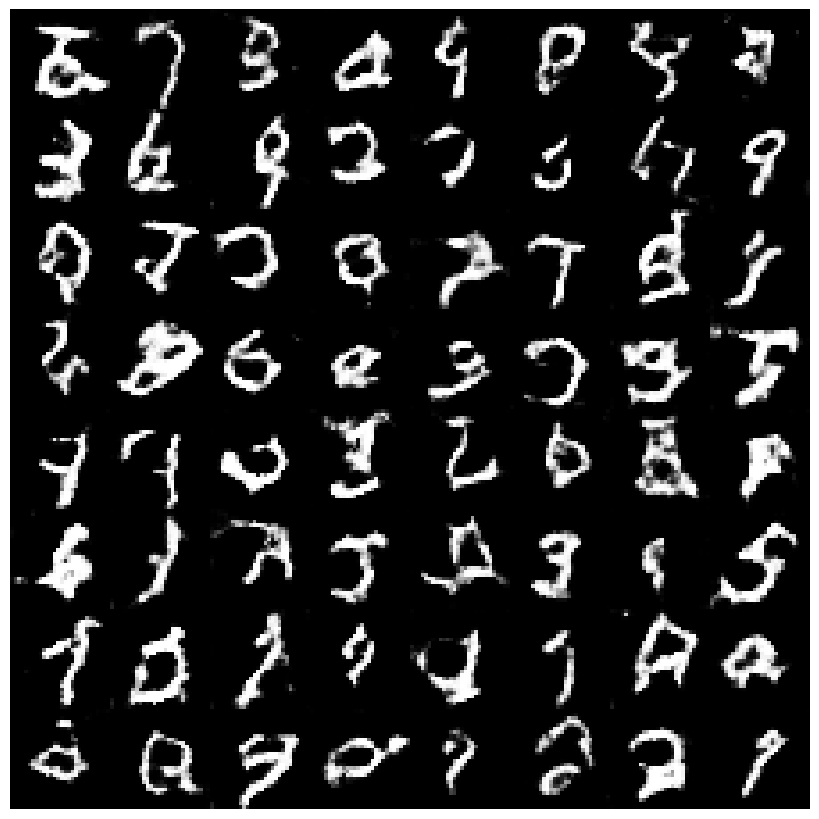

Epoch [6/100] - 6.00% complete | Discriminator Loss: 0.7826 | Generator Loss: 1.5471 | Time: 99.11s
Epoch [7/100] - 7.00% complete | Discriminator Loss: 0.7593 | Generator Loss: 1.6099 | Time: 99.90s
Epoch [8/100] - 8.00% complete | Discriminator Loss: 0.6817 | Generator Loss: 1.7875 | Time: 100.35s
Epoch [9/100] - 9.00% complete | Discriminator Loss: 0.6847 | Generator Loss: 1.8371 | Time: 100.20s
Epoch [10/100] - 10.00% complete | Discriminator Loss: 0.6595 | Generator Loss: 1.7973 | Time: 125.20s


<Figure size 640x480 with 0 Axes>

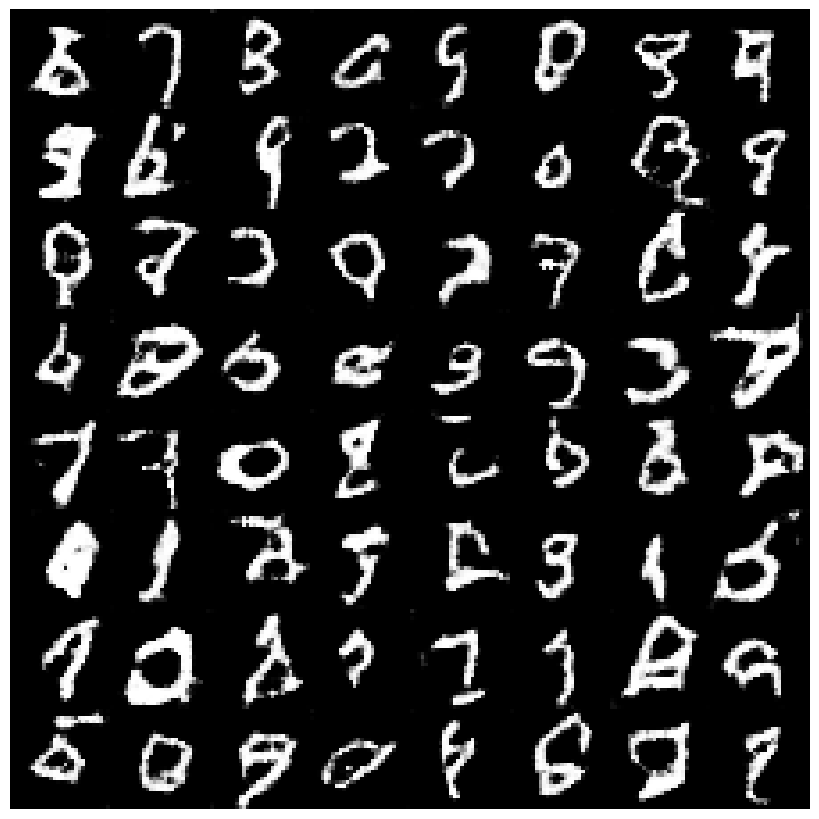

Epoch [11/100] - 11.00% complete | Discriminator Loss: 0.7239 | Generator Loss: 1.7310 | Time: 130.62s
Epoch [12/100] - 12.00% complete | Discriminator Loss: 0.7195 | Generator Loss: 1.7302 | Time: 124.75s
Epoch [13/100] - 13.00% complete | Discriminator Loss: 0.7276 | Generator Loss: 1.7155 | Time: 125.45s
Epoch [14/100] - 14.00% complete | Discriminator Loss: 0.7428 | Generator Loss: 1.6819 | Time: 125.56s
Epoch [15/100] - 15.00% complete | Discriminator Loss: 0.7564 | Generator Loss: 1.6646 | Time: 128.57s


<Figure size 640x480 with 0 Axes>

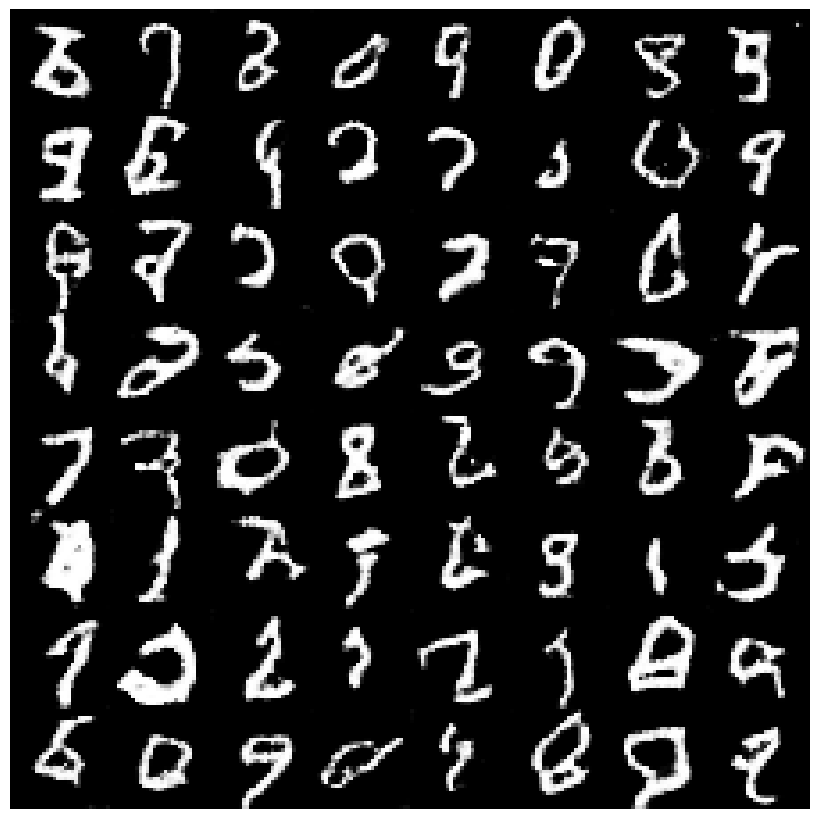

Epoch [16/100] - 16.00% complete | Discriminator Loss: 0.7675 | Generator Loss: 1.6716 | Time: 129.81s
Epoch [17/100] - 17.00% complete | Discriminator Loss: 0.7769 | Generator Loss: 1.6570 | Time: 131.78s
Epoch [18/100] - 18.00% complete | Discriminator Loss: 0.8185 | Generator Loss: 1.5975 | Time: 131.88s
Epoch [19/100] - 19.00% complete | Discriminator Loss: 0.7848 | Generator Loss: 1.6344 | Time: 100.09s
Epoch [20/100] - 20.00% complete | Discriminator Loss: 0.7961 | Generator Loss: 1.6129 | Time: 99.88s


<Figure size 640x480 with 0 Axes>

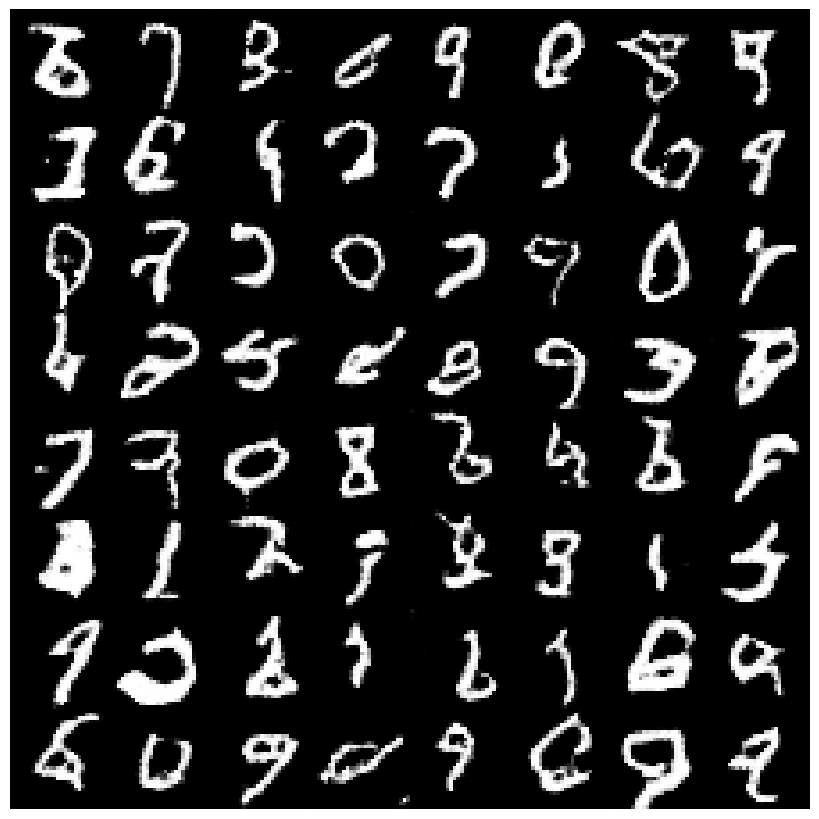

Epoch [21/100] - 21.00% complete | Discriminator Loss: 0.8177 | Generator Loss: 1.5809 | Time: 99.99s
Epoch [22/100] - 22.00% complete | Discriminator Loss: 0.8023 | Generator Loss: 1.6155 | Time: 100.84s
Epoch [23/100] - 23.00% complete | Discriminator Loss: 0.8125 | Generator Loss: 1.5987 | Time: 99.66s
Epoch [24/100] - 24.00% complete | Discriminator Loss: 0.7993 | Generator Loss: 1.5967 | Time: 100.12s
Epoch [25/100] - 25.00% complete | Discriminator Loss: 0.8200 | Generator Loss: 1.5943 | Time: 100.59s


<Figure size 640x480 with 0 Axes>

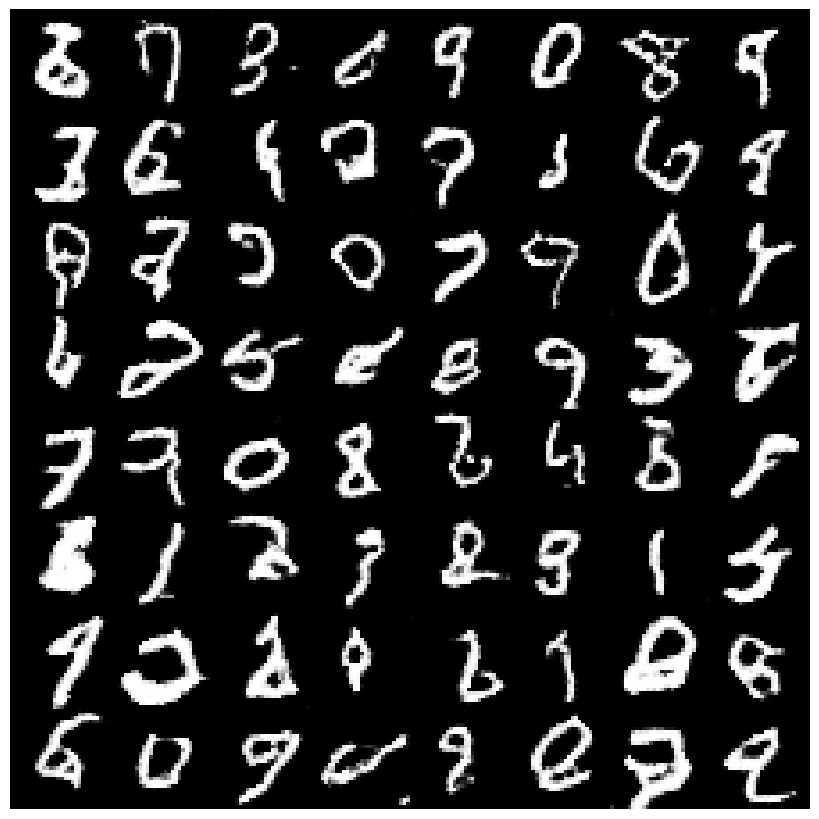

Epoch [26/100] - 26.00% complete | Discriminator Loss: 0.8088 | Generator Loss: 1.5882 | Time: 99.59s
Epoch [27/100] - 27.00% complete | Discriminator Loss: 0.8166 | Generator Loss: 1.6069 | Time: 102.29s
Epoch [28/100] - 28.00% complete | Discriminator Loss: 0.8146 | Generator Loss: 1.5953 | Time: 126.33s
Epoch [29/100] - 29.00% complete | Discriminator Loss: 0.8372 | Generator Loss: 1.6203 | Time: 131.10s
Epoch [30/100] - 30.00% complete | Discriminator Loss: 0.8307 | Generator Loss: 1.6005 | Time: 131.09s


<Figure size 640x480 with 0 Axes>

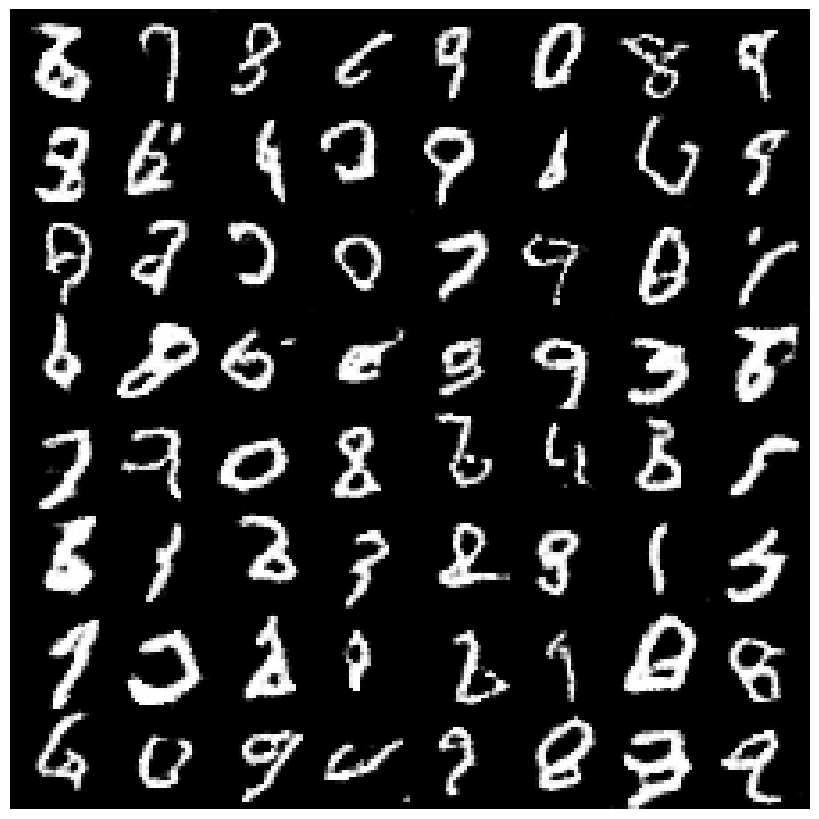

Epoch [31/100] - 31.00% complete | Discriminator Loss: 0.8378 | Generator Loss: 1.5951 | Time: 117.39s
Epoch [32/100] - 32.00% complete | Discriminator Loss: 0.8336 | Generator Loss: 1.5846 | Time: 99.04s
Epoch [33/100] - 33.00% complete | Discriminator Loss: 0.8613 | Generator Loss: 1.5846 | Time: 100.97s
Epoch [34/100] - 34.00% complete | Discriminator Loss: 0.8373 | Generator Loss: 1.5525 | Time: 99.11s
Epoch [35/100] - 35.00% complete | Discriminator Loss: 0.8297 | Generator Loss: 1.5908 | Time: 99.54s


<Figure size 640x480 with 0 Axes>

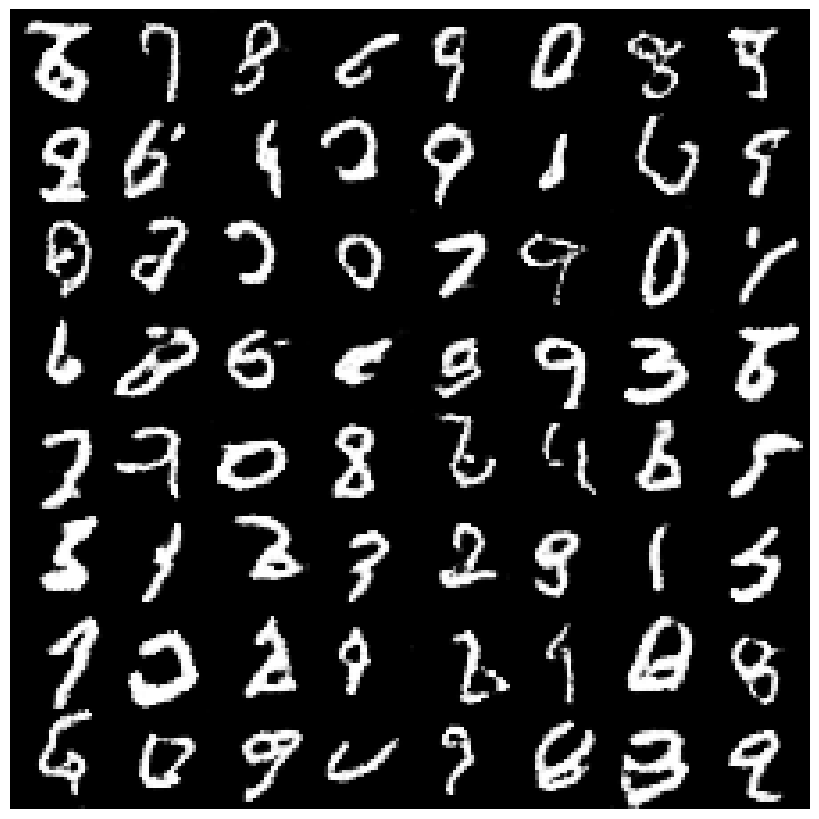

Epoch [36/100] - 36.00% complete | Discriminator Loss: 0.8405 | Generator Loss: 1.5777 | Time: 99.38s
Epoch [37/100] - 37.00% complete | Discriminator Loss: 0.8487 | Generator Loss: 1.5714 | Time: 99.24s
Epoch [38/100] - 38.00% complete | Discriminator Loss: 0.8669 | Generator Loss: 1.5676 | Time: 99.40s
Epoch [39/100] - 39.00% complete | Discriminator Loss: 0.8358 | Generator Loss: 1.5508 | Time: 101.22s
Epoch [40/100] - 40.00% complete | Discriminator Loss: 0.8472 | Generator Loss: 1.5649 | Time: 99.95s


<Figure size 640x480 with 0 Axes>

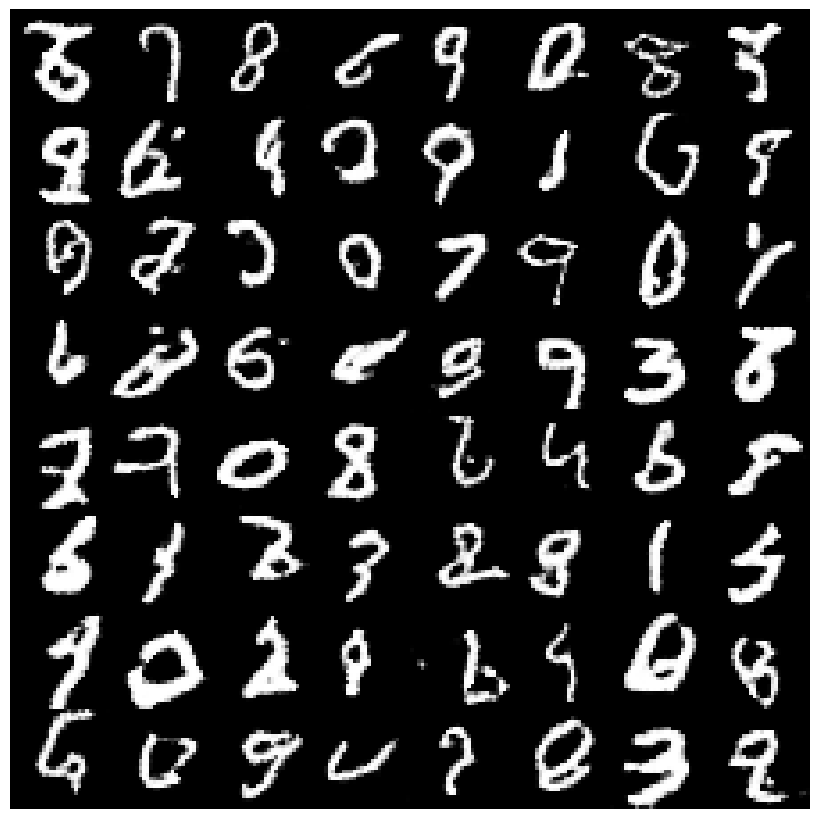

Epoch [41/100] - 41.00% complete | Discriminator Loss: 0.8673 | Generator Loss: 1.5851 | Time: 99.89s
Epoch [42/100] - 42.00% complete | Discriminator Loss: 0.8365 | Generator Loss: 1.5490 | Time: 99.40s
Epoch [43/100] - 43.00% complete | Discriminator Loss: 0.8473 | Generator Loss: 1.5691 | Time: 99.34s
Epoch [44/100] - 44.00% complete | Discriminator Loss: 0.8406 | Generator Loss: 1.5793 | Time: 100.00s
Epoch [45/100] - 45.00% complete | Discriminator Loss: 0.8385 | Generator Loss: 1.5606 | Time: 99.61s


<Figure size 640x480 with 0 Axes>

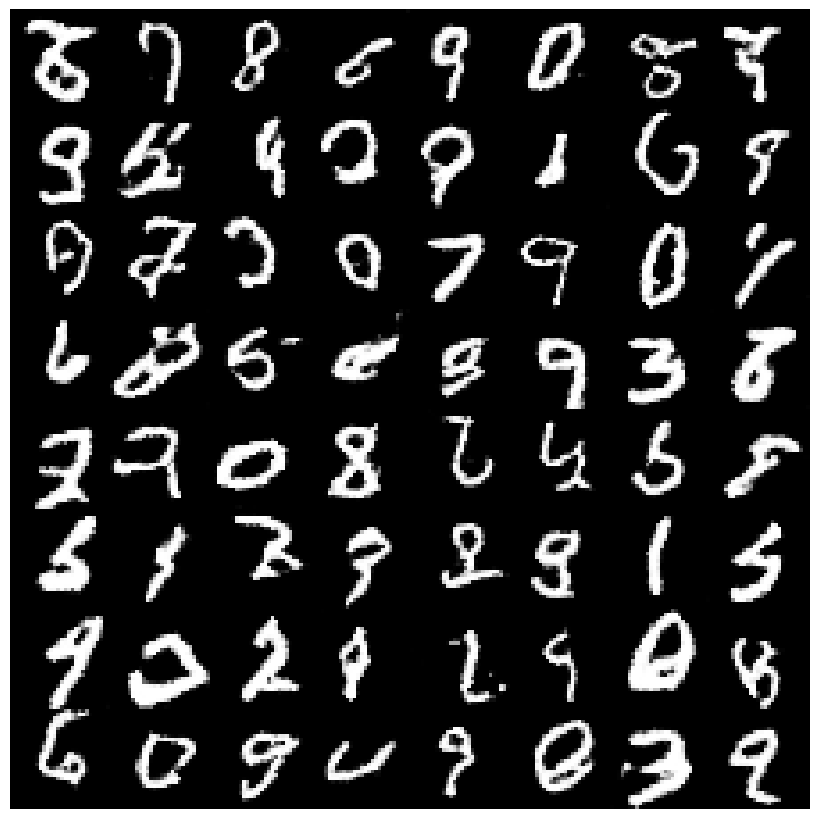

Epoch [46/100] - 46.00% complete | Discriminator Loss: 0.8533 | Generator Loss: 1.5621 | Time: 99.25s
Epoch [47/100] - 47.00% complete | Discriminator Loss: 0.8423 | Generator Loss: 1.5555 | Time: 99.83s
Epoch [48/100] - 48.00% complete | Discriminator Loss: 0.8538 | Generator Loss: 1.5527 | Time: 102.17s
Epoch [49/100] - 49.00% complete | Discriminator Loss: 0.8401 | Generator Loss: 1.5404 | Time: 125.27s
Epoch [50/100] - 50.00% complete | Discriminator Loss: 0.8510 | Generator Loss: 1.5543 | Time: 125.55s


<Figure size 640x480 with 0 Axes>

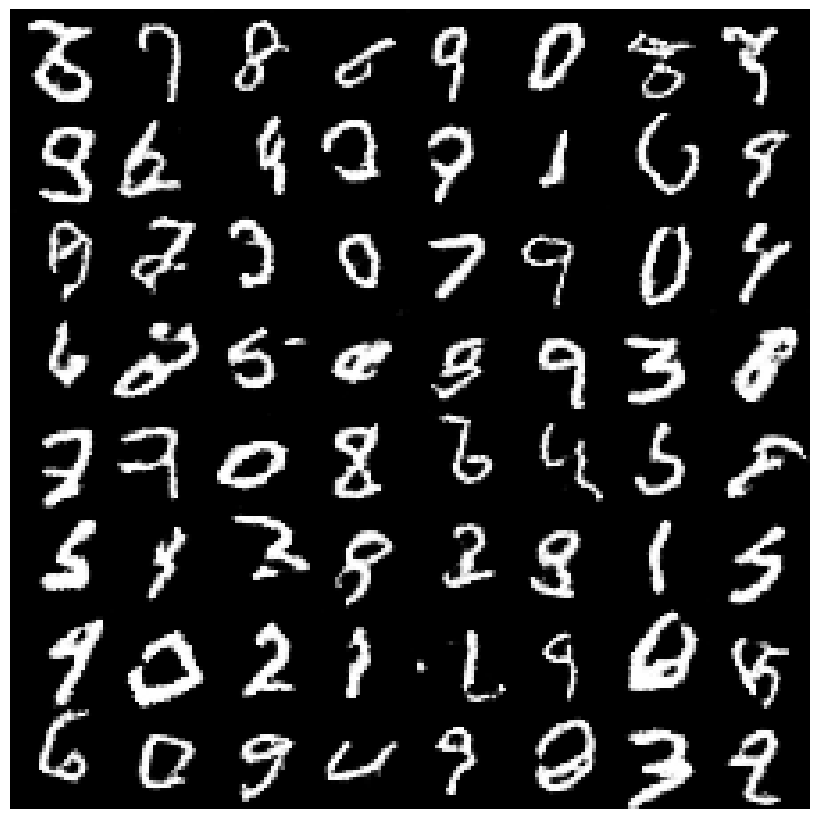

Epoch [51/100] - 51.00% complete | Discriminator Loss: 0.8550 | Generator Loss: 1.5577 | Time: 123.36s
Epoch [52/100] - 52.00% complete | Discriminator Loss: 0.8681 | Generator Loss: 1.5550 | Time: 125.52s
Epoch [53/100] - 53.00% complete | Discriminator Loss: 0.8445 | Generator Loss: 1.5542 | Time: 126.00s
Epoch [54/100] - 54.00% complete | Discriminator Loss: 0.8581 | Generator Loss: 1.5353 | Time: 126.18s
Epoch [55/100] - 55.00% complete | Discriminator Loss: 0.8633 | Generator Loss: 1.5490 | Time: 126.23s


<Figure size 640x480 with 0 Axes>

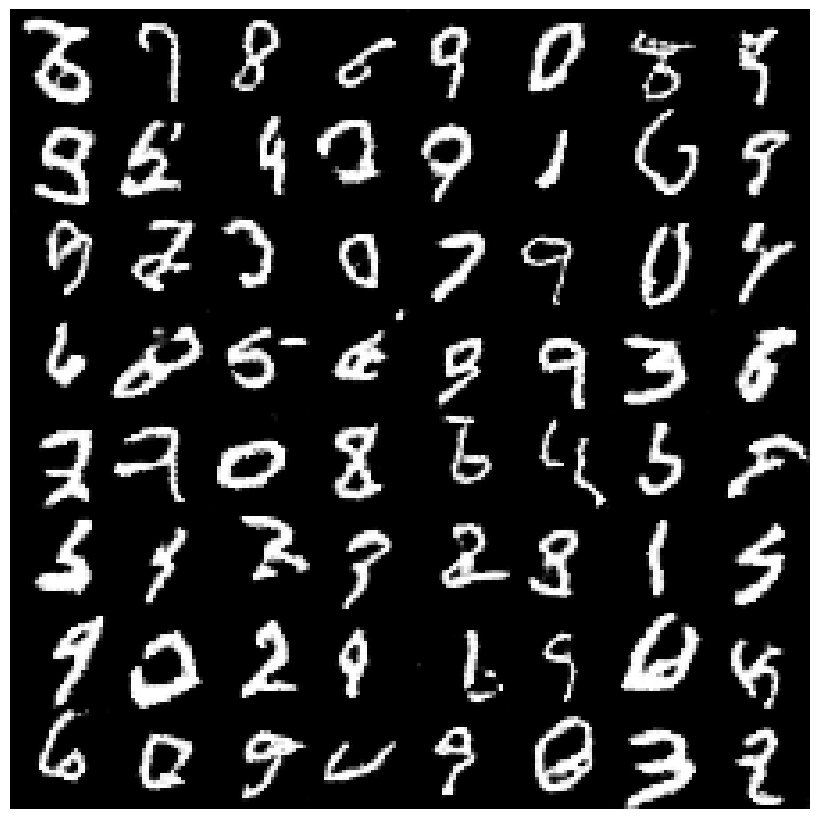

Epoch [56/100] - 56.00% complete | Discriminator Loss: 0.8540 | Generator Loss: 1.5389 | Time: 128.04s
Epoch [57/100] - 57.00% complete | Discriminator Loss: 0.8702 | Generator Loss: 1.5257 | Time: 132.80s
Epoch [58/100] - 58.00% complete | Discriminator Loss: 0.8485 | Generator Loss: 1.5188 | Time: 132.68s
Epoch [59/100] - 59.00% complete | Discriminator Loss: 0.8563 | Generator Loss: 1.5436 | Time: 132.27s
Epoch [60/100] - 60.00% complete | Discriminator Loss: 0.8723 | Generator Loss: 1.5507 | Time: 126.53s


<Figure size 640x480 with 0 Axes>

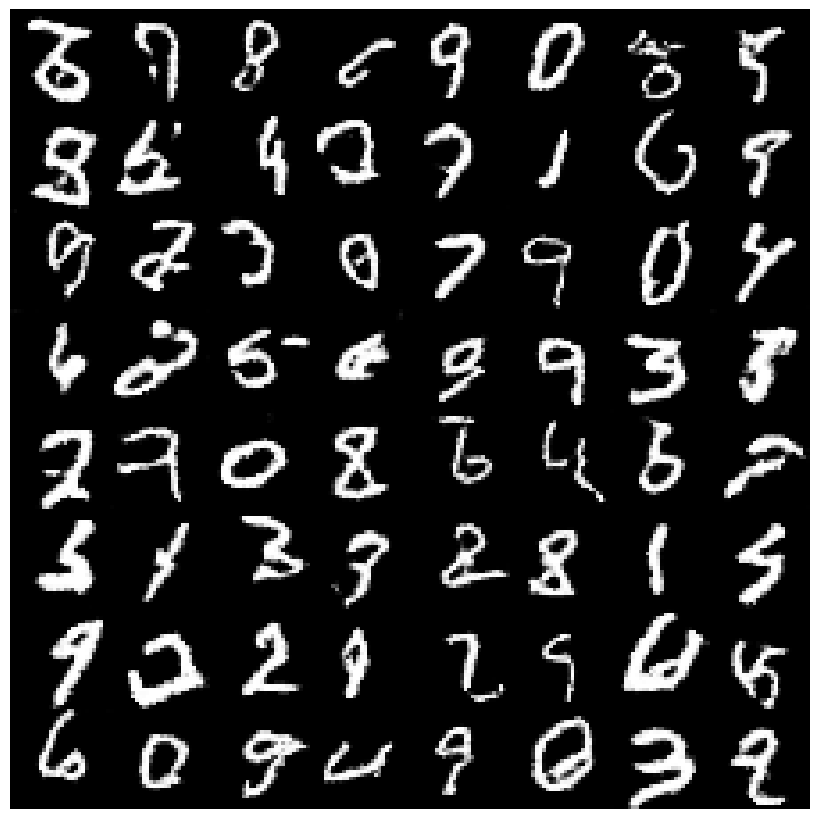

Epoch [61/100] - 61.00% complete | Discriminator Loss: 0.8677 | Generator Loss: 1.5420 | Time: 124.61s
Epoch [62/100] - 62.00% complete | Discriminator Loss: 0.8661 | Generator Loss: 1.5391 | Time: 123.12s
Epoch [63/100] - 63.00% complete | Discriminator Loss: 0.8683 | Generator Loss: 1.5146 | Time: 129.00s
Epoch [64/100] - 64.00% complete | Discriminator Loss: 0.8580 | Generator Loss: 1.5384 | Time: 124.73s
Epoch [65/100] - 65.00% complete | Discriminator Loss: 0.8954 | Generator Loss: 1.5513 | Time: 123.83s


<Figure size 640x480 with 0 Axes>

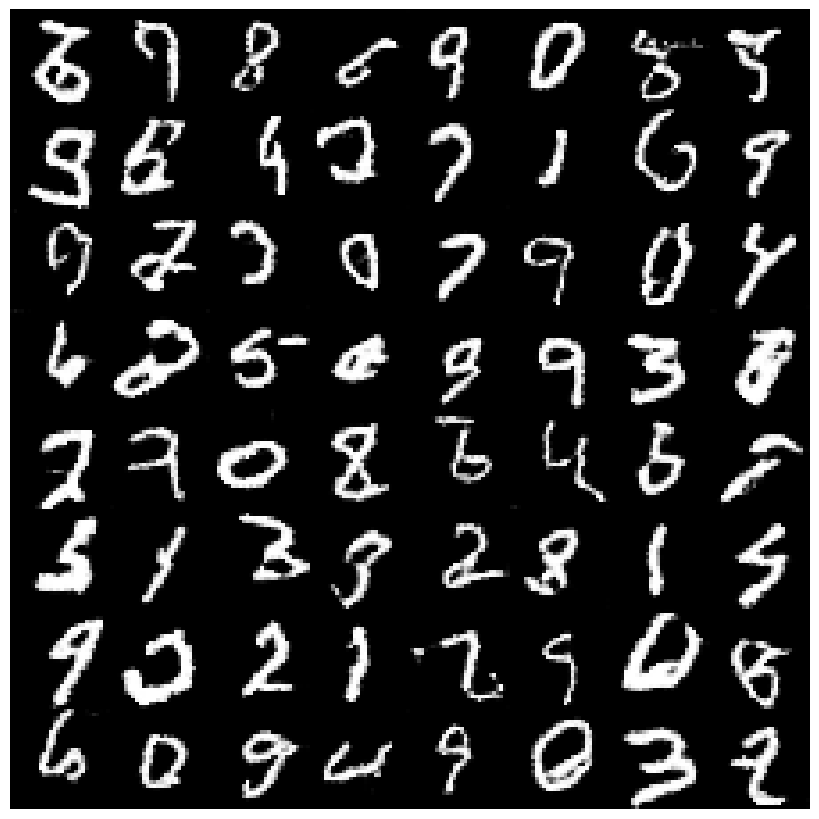

Epoch [66/100] - 66.00% complete | Discriminator Loss: 0.8797 | Generator Loss: 1.5006 | Time: 102.29s
Epoch [67/100] - 67.00% complete | Discriminator Loss: 0.8805 | Generator Loss: 1.5207 | Time: 99.68s
Epoch [68/100] - 68.00% complete | Discriminator Loss: 0.8769 | Generator Loss: 1.5446 | Time: 99.29s
Epoch [69/100] - 69.00% complete | Discriminator Loss: 0.8927 | Generator Loss: 1.5161 | Time: 98.97s
Epoch [70/100] - 70.00% complete | Discriminator Loss: 0.8820 | Generator Loss: 1.5063 | Time: 100.14s


<Figure size 640x480 with 0 Axes>

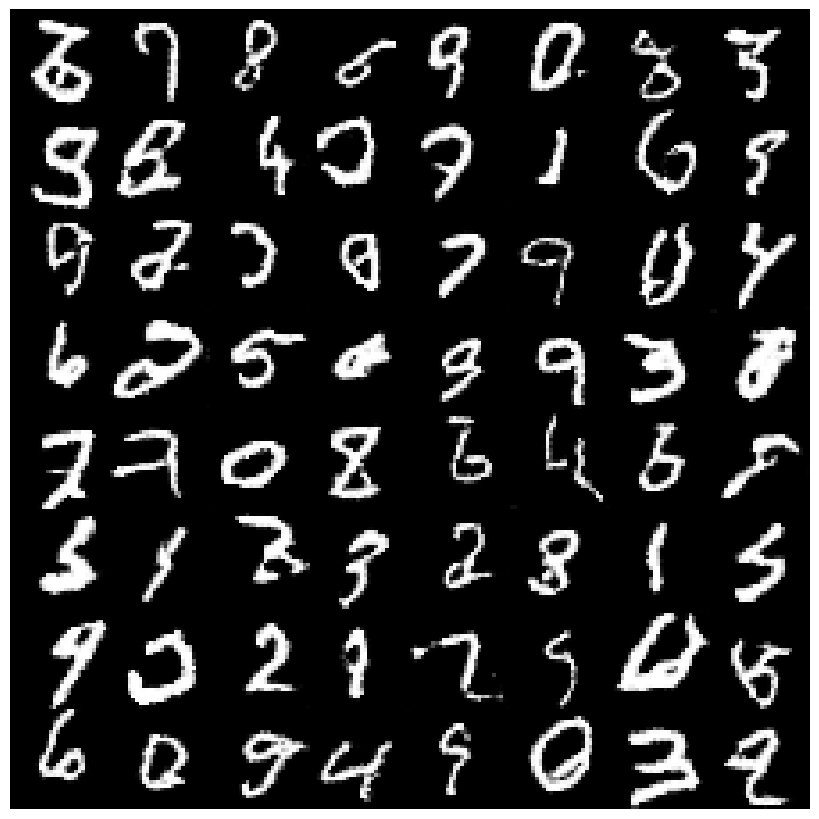

Epoch [71/100] - 71.00% complete | Discriminator Loss: 0.8784 | Generator Loss: 1.4912 | Time: 99.38s
Epoch [72/100] - 72.00% complete | Discriminator Loss: 0.8933 | Generator Loss: 1.5154 | Time: 99.03s
Epoch [73/100] - 73.00% complete | Discriminator Loss: 0.8809 | Generator Loss: 1.5090 | Time: 99.87s
Epoch [74/100] - 74.00% complete | Discriminator Loss: 0.8939 | Generator Loss: 1.5144 | Time: 99.92s
Epoch [75/100] - 75.00% complete | Discriminator Loss: 0.8854 | Generator Loss: 1.5009 | Time: 121.39s


<Figure size 640x480 with 0 Axes>

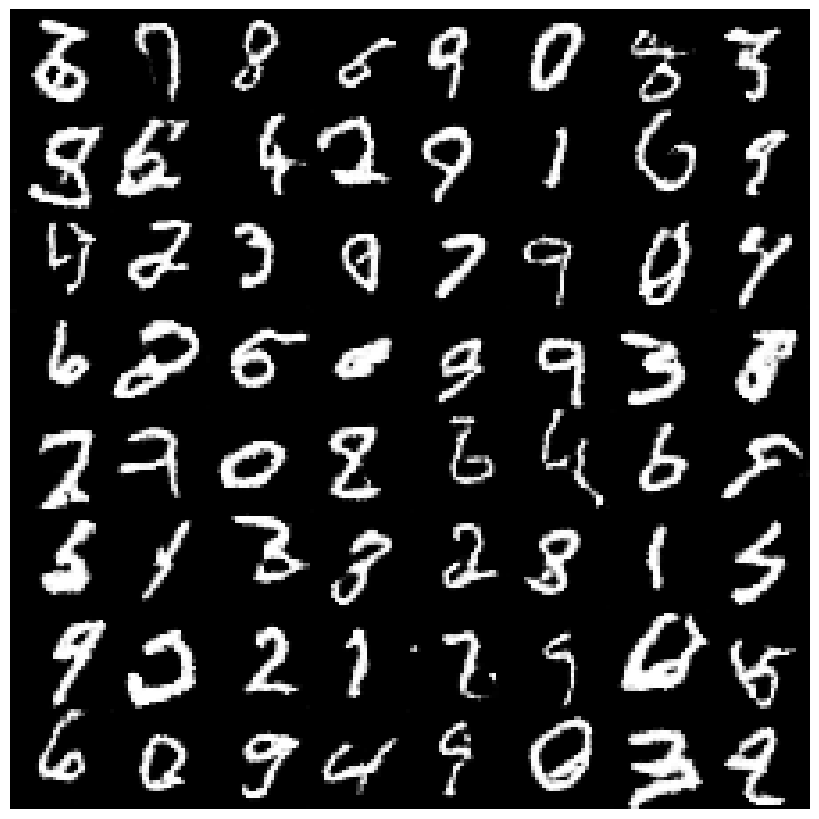

Epoch [76/100] - 76.00% complete | Discriminator Loss: 0.8977 | Generator Loss: 1.4870 | Time: 125.49s
Epoch [77/100] - 77.00% complete | Discriminator Loss: 0.8833 | Generator Loss: 1.5084 | Time: 126.99s
Epoch [78/100] - 78.00% complete | Discriminator Loss: 0.8858 | Generator Loss: 1.4967 | Time: 128.02s
Epoch [79/100] - 79.00% complete | Discriminator Loss: 0.8940 | Generator Loss: 1.4701 | Time: 126.75s
Epoch [80/100] - 80.00% complete | Discriminator Loss: 0.8879 | Generator Loss: 1.5013 | Time: 127.34s


<Figure size 640x480 with 0 Axes>

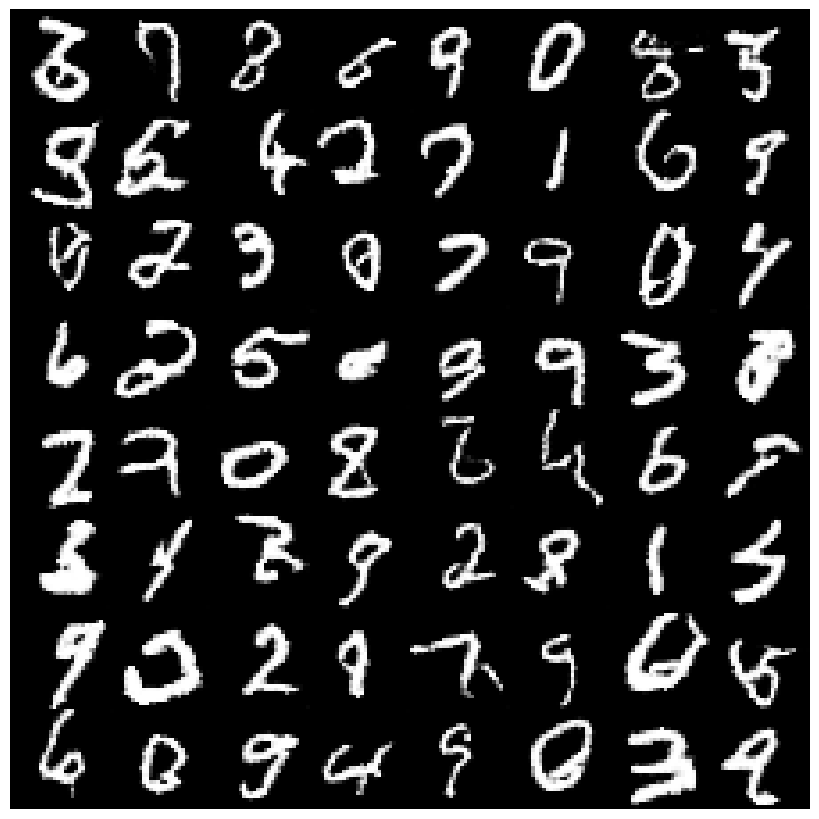

Epoch [81/100] - 81.00% complete | Discriminator Loss: 0.8913 | Generator Loss: 1.4918 | Time: 124.39s
Epoch [82/100] - 82.00% complete | Discriminator Loss: 0.9001 | Generator Loss: 1.4882 | Time: 124.61s
Epoch [83/100] - 83.00% complete | Discriminator Loss: 0.9191 | Generator Loss: 1.4901 | Time: 125.87s
Epoch [84/100] - 84.00% complete | Discriminator Loss: 0.9056 | Generator Loss: 1.4786 | Time: 123.36s
Epoch [85/100] - 85.00% complete | Discriminator Loss: 0.9107 | Generator Loss: 1.4663 | Time: 124.33s


<Figure size 640x480 with 0 Axes>

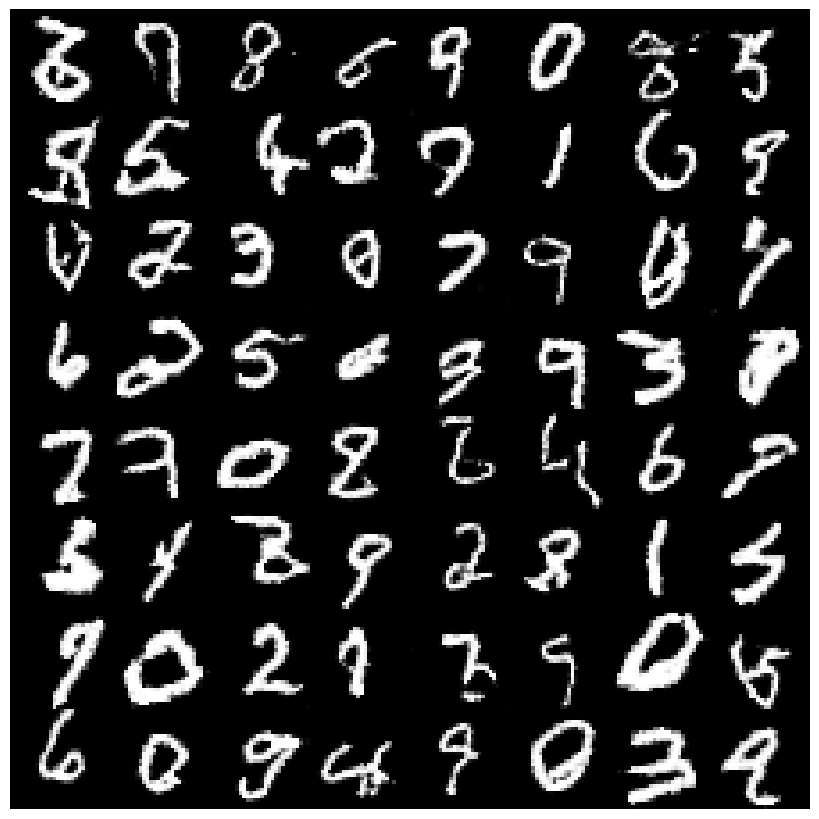

Epoch [86/100] - 86.00% complete | Discriminator Loss: 0.8957 | Generator Loss: 1.4983 | Time: 124.82s
Epoch [87/100] - 87.00% complete | Discriminator Loss: 0.8987 | Generator Loss: 1.4883 | Time: 126.88s
Epoch [88/100] - 88.00% complete | Discriminator Loss: 0.9078 | Generator Loss: 1.4708 | Time: 125.30s
Epoch [89/100] - 89.00% complete | Discriminator Loss: 0.9042 | Generator Loss: 1.4721 | Time: 125.12s
Epoch [90/100] - 90.00% complete | Discriminator Loss: 0.9121 | Generator Loss: 1.4670 | Time: 127.64s


<Figure size 640x480 with 0 Axes>

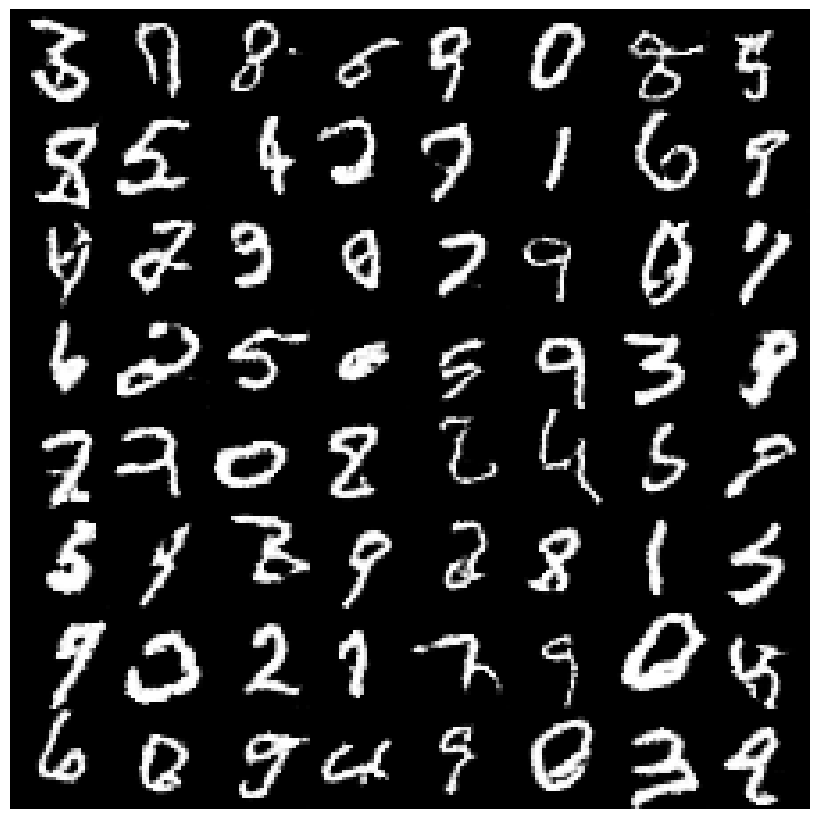

Epoch [91/100] - 91.00% complete | Discriminator Loss: 0.9260 | Generator Loss: 1.4545 | Time: 124.39s
Epoch [92/100] - 92.00% complete | Discriminator Loss: 0.9021 | Generator Loss: 1.4569 | Time: 125.99s
Epoch [93/100] - 93.00% complete | Discriminator Loss: 0.9132 | Generator Loss: 1.4420 | Time: 122.92s
Epoch [94/100] - 94.00% complete | Discriminator Loss: 0.9506 | Generator Loss: 1.4637 | Time: 123.66s
Epoch [95/100] - 95.00% complete | Discriminator Loss: 0.9096 | Generator Loss: 1.4545 | Time: 121.65s


<Figure size 640x480 with 0 Axes>

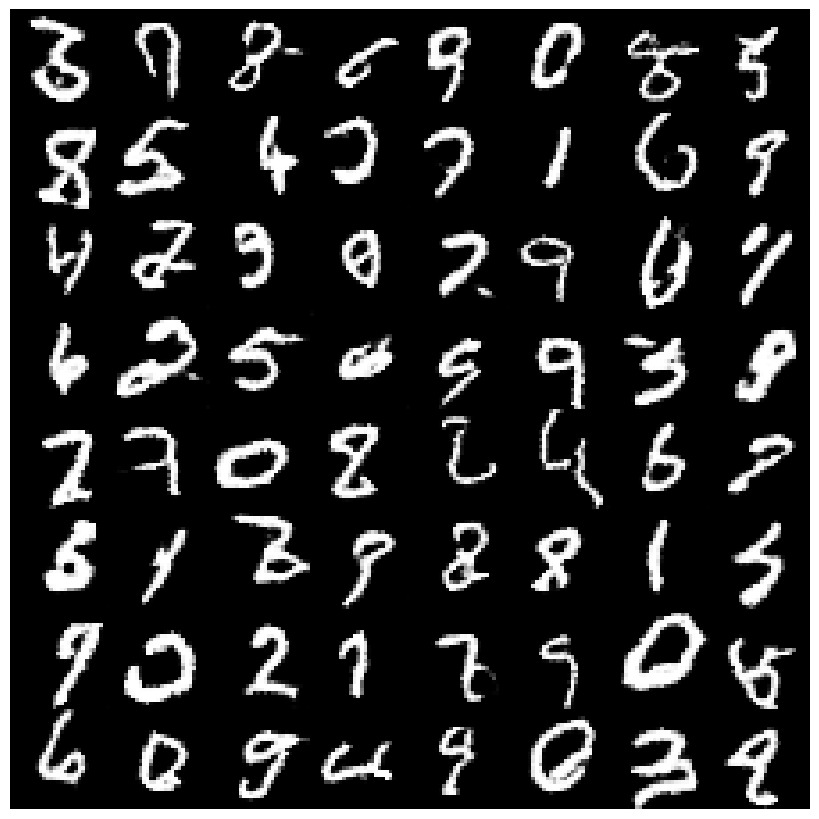

Epoch [96/100] - 96.00% complete | Discriminator Loss: 0.9126 | Generator Loss: 1.4610 | Time: 1651.36s
Epoch [97/100] - 97.00% complete | Discriminator Loss: 0.9053 | Generator Loss: 1.4397 | Time: 120.76s
Epoch [98/100] - 98.00% complete | Discriminator Loss: 0.9349 | Generator Loss: 1.4582 | Time: 116.88s
Epoch [99/100] - 99.00% complete | Discriminator Loss: 0.9270 | Generator Loss: 1.4384 | Time: 126.40s
Epoch [100/100] - 100.00% complete | Discriminator Loss: 0.9217 | Generator Loss: 1.4147 | Time: 103.65s


<Figure size 640x480 with 0 Axes>

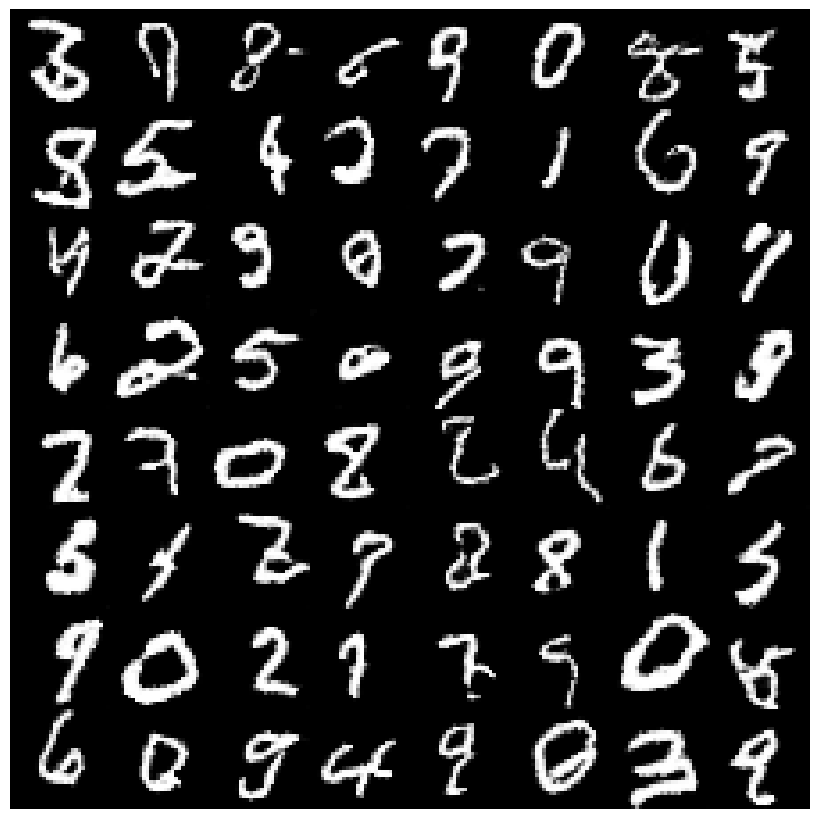

<Figure size 640x480 with 0 Axes>

In [23]:
batch_size = 128

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
total_batches = len(train_loader)

real_label_noise = 0.95 + 0.05 * torch.rand(batch_size, 1, device=device) # I think I switched the labels.. and it works and does not work the other way around.. ???
fake_label_noise = 0.05 * torch.rand(batch_size, 1, device=device)

gan = GAN(data_loader=train_loader, batch_size=batch_size, latent_dimension=64, device=device)
gan.train(100)

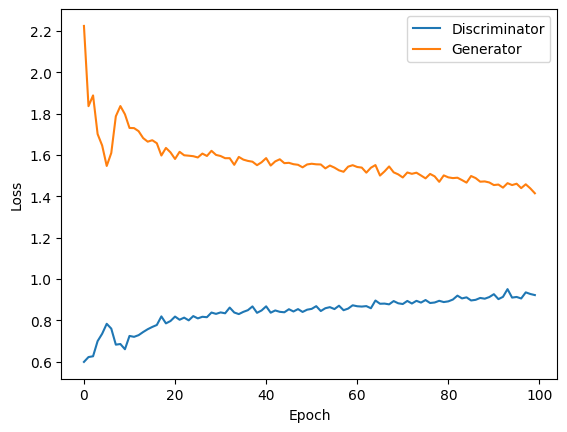

In [25]:
gan.plot_training_loss()

The next step is to use the Wasserstein-1 metric to turn this GAN in a Wasserstein GAN (WGAN). The loss function given by Goodfellow is then replaced by

$$L = \mathbb{E}_{\tilde X\sim\mathbb{P}_G}[D(\tilde X)] - \mathbb{E}_{X\sim\mathbb{P}_R}[D(X)] +\lambda \mathbb{E}_{\tilde X\sim\mathbb{P}_G}[(||\nabla_{\tilde x}D(\tilde x)||_2-1)^2]$$

Claude changes the functions compute_gradient_penalty, forward_discriminator_batch, forward_generator_batch

In [31]:
class WGAN_GP(nn.Module):
    """A Generative Adversarial Network (GAN) model.""" 
    def __init__(self, data_loader, batch_size, latent_dimension=64, lr_generator=2e-4, lr_discriminator=4e-4,
                 device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
        super().__init__()

        self.lossfunction = nn.BCELoss()
        self.latent_dimension = latent_dimension 
        self.fixed_noise = torch.randn(latent_dimension, latent_dimension, device=device)           

        self.generator = GeneratorConv(latent_dimension).to(device)
        self.discriminator = DiscriminatorConv().to(device)

        self.optimizer_gen = optim.Adam(self.generator.parameters(), lr=lr_generator, betas=(0.5, 0.999))
        self.optimizer_disc = optim.Adam(self.discriminator.parameters(), lr=lr_discriminator, betas=(0.5, 0.999))

        self.data_loader = data_loader

        self.K = 3
        self.device = device
        self.batch_size = batch_size
        self.discriminate_loss = []
        self.generate_loss = []

        
    def compute_gradient_penalty(self, real_samples, fake_samples):
        """Calculates the gradient penalty loss for WGAN-GP"""
        # Random weight term for interpolation between real and fake samples
        alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=self.device)
    
        # Get random interpolation between real and fake samples
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        d_interpolates = self.discriminator(interpolates)
    
        # Get gradient w.r.t. interpolates
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(d_interpolates, device=self.device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
    
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def forward_discriminator_batch(self, batch):
        """WGAN-GP discriminator (critic) loss"""
        self.optimizer_disc.zero_grad()
    
        real_images = batch[0].to(self.device)
        batch_size = real_images.size(0)
    
        # Generate fake images
        noise = torch.randn(batch_size, self.latent_dimension, device=self.device)
        fake_images = self.generator(noise)
    
        # Real images
        real_validity = self.discriminator(real_images)
        # Fake images
        fake_validity = self.discriminator(fake_images.detach())
    
        # Gradient penalty
        gradient_penalty = self.compute_gradient_penalty(real_images, fake_images.detach())
    
        # Discriminator loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + 10.0 * gradient_penalty
    
        d_loss.backward()
        self.optimizer_disc.step()
    
        return d_loss.item()

    def forward_generator_batch(self, batch):
        """WGAN generator loss"""
        self.optimizer_gen.zero_grad()
    
        # Generate fake images
        noise = torch.randn(self.batch_size, self.latent_dimension, device=self.device)
        fake_images = self.generator(noise)
    
        # Loss measures generator's ability to fool the discriminator
        fake_validity = self.discriminator(fake_images)
        g_loss = -torch.mean(fake_validity)
    
        g_loss.backward()
        self.optimizer_gen.step()
    
        return g_loss.item()

    def forward_gan(self, epoch, num_epochs):
        """Performs a forward pass through the GAN for a batch of images and updates the weights of the discriminator and generator."""
        running_loss_disc = 0.0
        running_loss_gen = 0.0
        start_time = time.time()

        for _, batch in enumerate(self.data_loader): # for batch in self.data_loader: # should work too. right?
            for _ in range(self.K):
                running_loss_disc += self.forward_discriminator_batch(batch) 
            running_loss_gen += self.forward_generator_batch(batch)
        avg_loss_disc = running_loss_disc / (self.K * len(self.data_loader))
        avg_loss_gen = running_loss_gen / len(self.data_loader)

        self.discriminate_loss.append(avg_loss_disc)
        self.generate_loss.append(avg_loss_gen)

        progress = (epoch + 1) / num_epochs * 100
        print(f"Epoch [{epoch + 1}/{num_epochs}] - {progress:.2f}% complete | "
          f"Discriminator Loss: {avg_loss_disc:.4f} | Generator Loss: {avg_loss_gen:.4f} | "
          f"Time: {time.time() - start_time:.2f}s")
            

    def train(self, num_epochs):
        """Trains the GAN for a specified number of epochs."""
        for epoch in range(num_epochs):

            self.forward_gan(epoch=epoch, num_epochs=num_epochs)

            if (epoch+1) % 3 == 0:
                self.plot_generated_samples_from_latent(epoch=epoch, save=True)

        self.save_parameters()
            
    
    def save_parameters(self):  
        current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        torch.save(self.generator.state_dict(), f"generate_1_{current_time}.pth")
        torch.save(self.discriminator.state_dict(), f"discriminate_1_{current_time}.pth")


    def plot_training_loss(self):
        plt.plot(self.discriminate_loss[0:])
        plt.plot(self.generate_loss[0:])
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend(["Discriminator", "Generator"])
        plt.show()
    

    def plot_generated_samples_from_latent(self, epoch, save=False):
        images = self.generator(self.fixed_noise)
        images = images.detach()

        _, axes = plt.subplots(8, 8, figsize=(8, 8))
        for i, ax in enumerate(axes.flat):
            img = images[i].squeeze().numpy()  # Remove extra dimension and convert to numpy array
            ax.imshow(img, cmap='gray')
            ax.axis('off') 
        plt.tight_layout(pad=0)
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

        if save:
            plt.savefig(f"{os.getcwd()}/images/MNIST_ConvGAN_Noise Images at Epoch {epoch + 1}.png")

Epoch [1/50] - 2.00% complete | Discriminator Loss: -0.4650 | Generator Loss: -0.2396 | Time: 174.56s
Epoch [2/50] - 4.00% complete | Discriminator Loss: -0.4763 | Generator Loss: -0.2247 | Time: 178.35s
Epoch [3/50] - 6.00% complete | Discriminator Loss: -0.4852 | Generator Loss: -0.2217 | Time: 177.73s


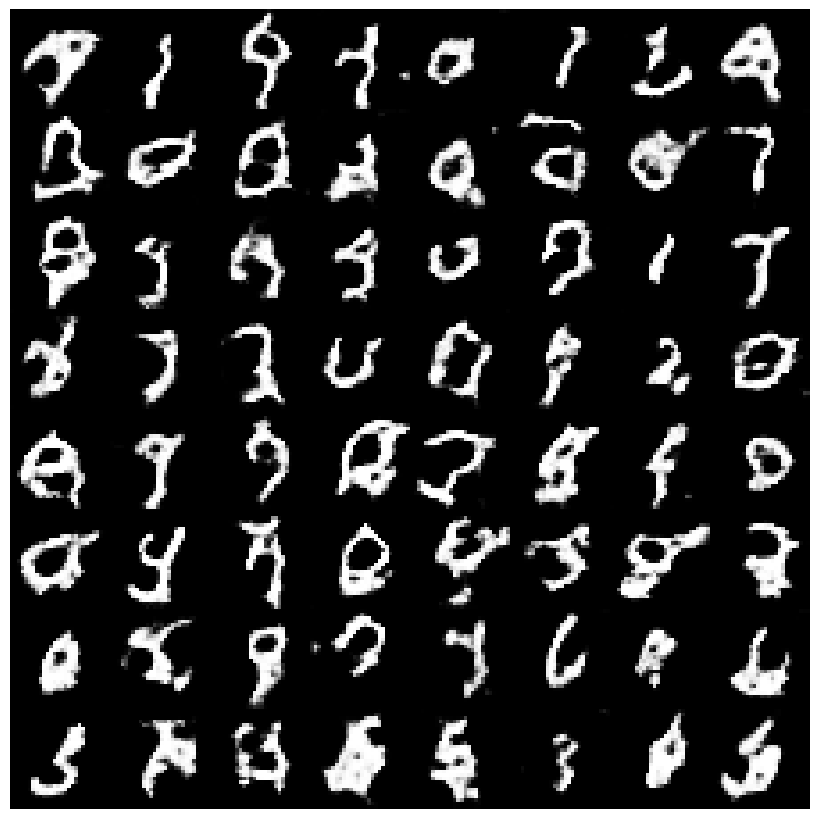

Epoch [4/50] - 8.00% complete | Discriminator Loss: -0.4703 | Generator Loss: -0.2352 | Time: 178.00s
Epoch [5/50] - 10.00% complete | Discriminator Loss: -0.4794 | Generator Loss: -0.2242 | Time: 180.30s
Epoch [6/50] - 12.00% complete | Discriminator Loss: -0.5223 | Generator Loss: -0.2019 | Time: 219.16s


<Figure size 640x480 with 0 Axes>

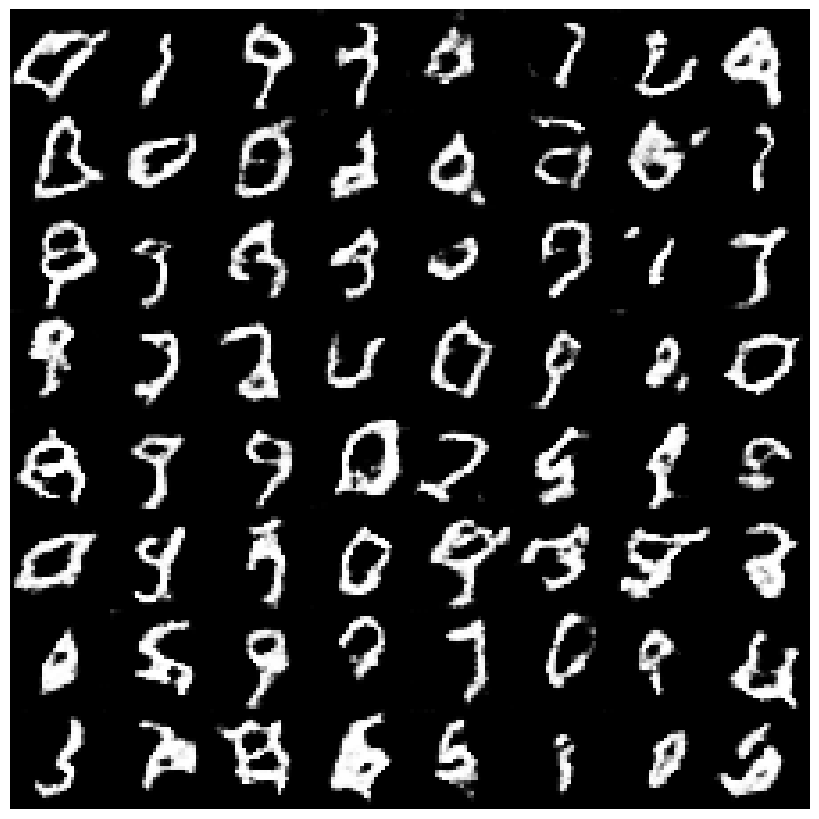

Epoch [7/50] - 14.00% complete | Discriminator Loss: -0.5446 | Generator Loss: -0.1946 | Time: 231.14s
Epoch [8/50] - 16.00% complete | Discriminator Loss: -0.5569 | Generator Loss: -0.1826 | Time: 230.36s
Epoch [9/50] - 18.00% complete | Discriminator Loss: -0.5667 | Generator Loss: -0.1844 | Time: 234.41s


<Figure size 640x480 with 0 Axes>

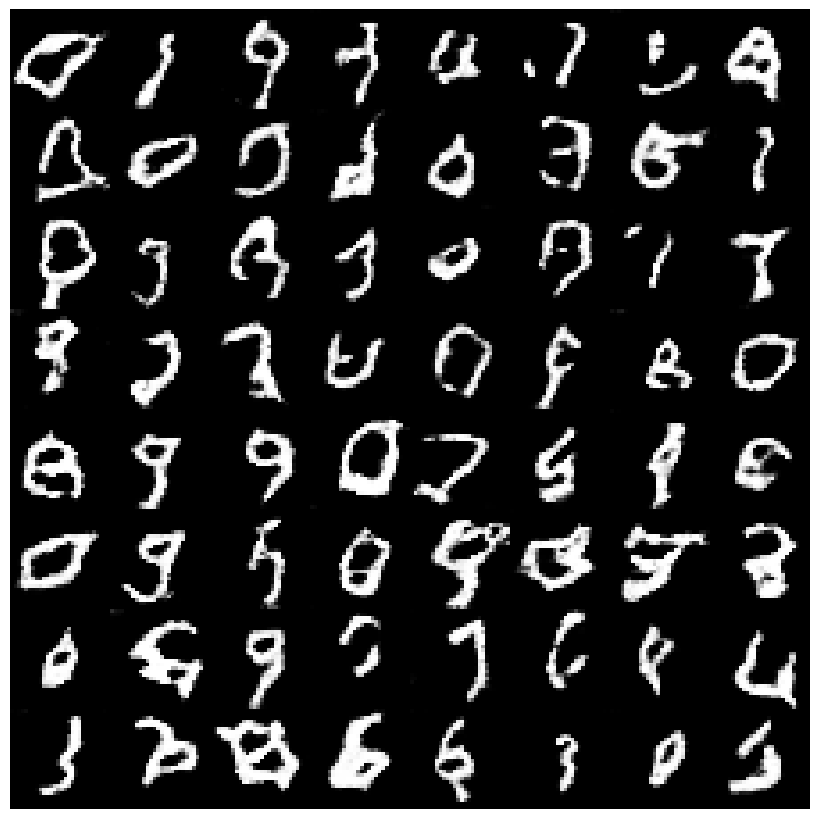

Epoch [10/50] - 20.00% complete | Discriminator Loss: -0.5874 | Generator Loss: -0.1723 | Time: 225.58s
Epoch [11/50] - 22.00% complete | Discriminator Loss: -0.5768 | Generator Loss: -0.1710 | Time: 226.19s
Epoch [12/50] - 24.00% complete | Discriminator Loss: -0.6263 | Generator Loss: -0.1513 | Time: 225.52s


<Figure size 640x480 with 0 Axes>

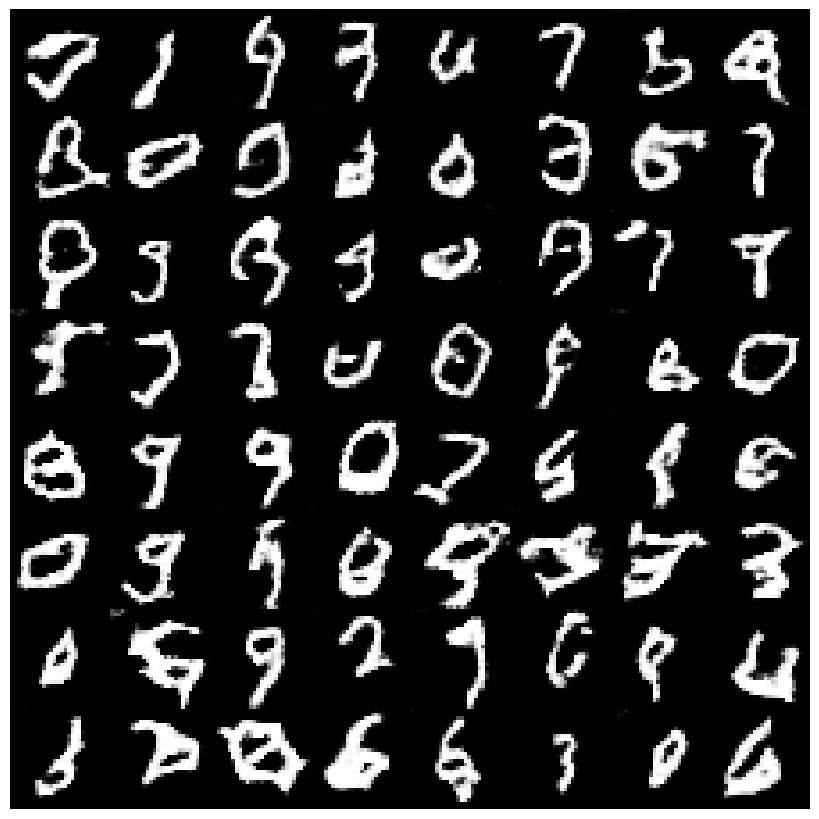

Epoch [13/50] - 26.00% complete | Discriminator Loss: -0.5792 | Generator Loss: -0.1639 | Time: 224.57s
Epoch [14/50] - 28.00% complete | Discriminator Loss: -0.5962 | Generator Loss: -0.1548 | Time: 205.11s
Epoch [15/50] - 30.00% complete | Discriminator Loss: -0.5968 | Generator Loss: -0.1605 | Time: 171.69s


<Figure size 640x480 with 0 Axes>

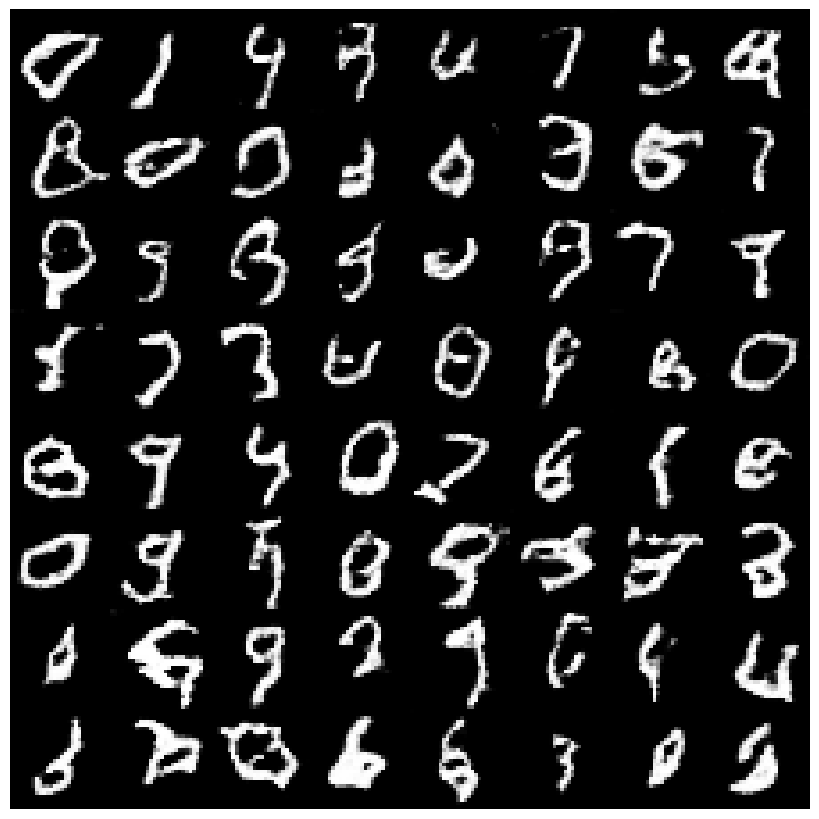

Epoch [16/50] - 32.00% complete | Discriminator Loss: -0.5931 | Generator Loss: -0.1556 | Time: 173.05s
Epoch [17/50] - 34.00% complete | Discriminator Loss: -0.5970 | Generator Loss: -0.1642 | Time: 172.19s


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [33]:
batch_size = 128
latent_dimension = 64
num_epochs = 5  # You might want to increase this as WGANs typically need more epochs
lr_generator = 2e-4    # Added: lower learning rate for WGAN-GP
lr_discriminator = 1e-4  # Added: lower learning rate for WGAN-GP
n_critic = 3  # Added: number of critic updates per generator update
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataLoader remains the same
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Instantiate the GAN with WGAN-GP loss - pass the new parameters
gan = WGAN_GP(data_loader=train_loader, 
              batch_size=batch_size, 
              latent_dimension=latent_dimension,
              lr_generator=lr_generator,
              lr_discriminator=lr_discriminator,
              device=device)

gan.train(50)

In [34]:
gan.save_parameters()